# Looking Predictive Model

En este cuaderno se tratara de buscar el mejor modelo de aprendizaje supervisado para tratar de predecir el porcentaje de que una canción sea hit o no, acorde a las caracteristicas que hemos obtenido.

In [33]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
import joblib
plt.rcParams['figure.figsize'] = 8, 6

- Definimos función que usaremos para extraer las caracteristicas necesarias de una canción para hacer una predicción de probabilidad de ser un *hit* una vez entrenado el modelo.

In [5]:
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials

# sp_cid: Sustituir por spotify client id (str)
# sp_secret: Sustituir por spotify secret id (str)
client_credentials_manager = SpotifyClientCredentials(client_id='01ec25b32db847e3aeb622ebe1a894c8', client_secret='cd8d3b7666164ea5943688215d9226c2') 
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager, requests_timeout=50)

def find_song():
    print("Artista: ", end="")
    artist = input()
    print("Titulo: ", end="")
    title = input()
    Searched = str (title + " " + artist)
    track = sp.search(Searched)
    try:
        id_track = track["tracks"]["items"][0]["uri"]
        track = sp.track(id_track)
        track_feat = sp.audio_features(id_track)
        song = [[track_feat[0]["danceability"], track_feat[0]["energy"], track_feat[0]["key"],
        track_feat[0]["loudness"], track_feat[0]["mode"], track_feat[0]["speechiness"],
        track_feat[0]["acousticness"], track_feat[0]["instrumentalness"], track_feat[0]["liveness"],
        track_feat[0]["valence"], track_feat[0]["tempo"],track_feat[0]["time_signature"],
                track["duration_ms"]]]
        
        print ("Canción elegida:",track["name"], "de", track["artists"][0]["name"] )
        return song
    except:
        print ("ERROR: Titulo no encontrado")

- Se lee dataframe y se realiza *split* para los entrenamientos y test.

In [6]:
df_songs = pd.read_csv("../Data/fusion_songs_1993_2020_to_train.csv")

In [7]:
df_songs.head()

,artist,title,id,year_chart,date_chart,release_date,collaboration,rank,weeks,isNew,peakPos,lastPos,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_ms,popularity_artist,popularity_song,genres,album,label,song_lyrics,target
0,PARTYNEXTDOOR,Come and See Me (feat. Drake),1wZqJM5FGDEl3FjHDxDyQd,2016.0,2016-12-31,2016-08-12,True,63.0,24.0,False,55.0,56.0,0.717,0.347,11,-10.265,0,0.0636,0.0511,0.000002,0.087,0.0589,84.987,4,235477,83,73,"['pop', 'pop rap', 'rap', 'toronto rap', 'trap...",PARTYNEXTDOOR 3 (P3),OVO Sound/Warner Records,Usually hear the phone late night like now\nSh...,1
1,Macy Todd,I've Got a Feelin',2xnIFEOXHXlzIyJN0itwBX,NaN,NaN,2016-07-15,False,NaN,NaN,NaN,NaN,NaN,0.475,0.546,10,-7.140,0,0.0399,0.3570,0.000056,0.330,0.4930,183.895,3,220533,27,0,[],I've Got a Feelin',Macy Todd Music,NaN,0
2,The Japanese House,You Seemed so Happy,0NuIfPuBhUAt4aA4HP0rUu,NaN,NaN,2019-03-01,False,NaN,NaN,NaN,NaN,NaN,0.519,0.888,11,-6.232,1,0.1170,0.0406,0.000000,0.227,0.4160,149.938,4,162485,63,52,"['art pop', 'electropop', 'indie pop', 'indie ...",Good At Falling,Dirty Hit/The Japanese House PS,NaN,0
3,Krzysztof Komeda,Rosemary's Baby Main Theme Vocal,28D0Hfi6x9zAeGr1sDYBkb,NaN,NaN,2008-07-21,False,NaN,NaN,NaN,NaN,NaN,0.265,0.255,3,-11.284,1,0.0358,0.8410,0.138000,0.247,0.1100,116.572,3,152866,32,33,['polish jazz'],Rosemary's Baby,Harkit Records,NaN,0
4,Flyte,White Roses,5xxHfQuaXGEBHtsGbSXwI7,NaN,NaN,2019-07-05,True,NaN,NaN,NaN,NaN,NaN,0.530,0.633,10,-7.078,1,0.0283,0.3910,0.015200,0.142,0.6050,140.186,4,206445,46,53,['english indie rock'],White Roses,Universal-Island Records Ltd.,NaN,0


In [8]:
X = df_songs.loc[:,"danceability":"duration_ms"]
y = df_songs.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

## Random Forest
- El primer modelo que usaremos será *random forest*

In [34]:
from sklearn.ensemble import RandomForestClassifier

- Probamos el modelo de *random forest* con la configuración por defecto dada por *sklearn*

In [7]:
forest = RandomForestClassifier ()

In [8]:
%%time
cross_val_score(forest,X_train,y_train,cv=5).mean()

Wall time: 12.3 s


0.7599378464693165

Vemos el *score* obtenido utilizando *cross validation*.

- La función anterior no almacena el entrenamiento generado, por ello entrenamos *random forest* con la configuración por defecto, pero ahora sobre todos los datos de entrenamiento.

In [9]:
forest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [10]:
print("Precisión sobre datos de pruebas: {:.4f}"
      .format(forest.score(X_test, y_test)))
print("Precisión sobre datos de train: {:.4f}"
      .format(forest.score(X_train, y_train)))

Precisión sobre datos de pruebas: 0.7631
Precisión sobre datos de train: 0.9998


los modelos basados en árboles de decisión tenderán al sobreentrenamiento, por lo que la mejor manera es configurarlos utilizando las técnicas de *cross validation* y obtener el mayor *score* posible, que aunque los resultados obtenidos con todo el dataset de entrenamiento den más bajos, sean modelos más generalizables.

- Calculamos el *score* para diferentes números de estimadores con un *cross val* de 5 que es el que toma por defecto la función, y analizaremos los resultados obtenidos.

In [11]:
param_range = [40,50,60,90,100,130,150,200,250,300]
train_score, test_score= validation_curve(
                                forest,
                                X = X_train, y = y_train, 
                                param_name = 'n_estimators', 
                               param_range=param_range,
                                scoring="accuracy")

In [12]:
print("Numero de estimadores para un Cross_val 5 (test) y para todo dataset de entrenamiento (train)")
print ('n_estimators 40 en test:',test_score[0].mean(),'en train:',train_score[0].mean())
print ('n_estimators 50 en test:',test_score[1].mean(),'en train:',train_score[1].mean())
print ('n_estimators 60 en test:',test_score[2].mean(),'en train:',train_score[2].mean())
print ('n_estimators 90 en test:',test_score[3].mean(),'en train:',train_score[3].mean())
print ('n_estimators 100 en test:',test_score[4].mean(),'en train:',train_score[4].mean())
print ('n_estimators 130 en test:',test_score[5].mean(),'en train:',train_score[5].mean())
print ('n_estimators 150 en test:',test_score[6].mean(),'en train:',train_score[6].mean())
print ('n_estimators 200 en test:',test_score[7].mean(),'en train:',train_score[7].mean())
print ('n_estimators 250 en test:',test_score[8].mean(),'en train:',train_score[8].mean())
print ('n_estimators 300 en test:',test_score[9].mean(),'en train:',train_score[9].mean())

Numero de estimadores para un Cross_val 5 (test) y para todo dataset de entrenamiento (train)
n_estimators 40 en test: 0.7605895033130505 en train: 0.9996090157168964
n_estimators 50 en test: 0.7578520096414392 en train: 0.9997393486770424
n_estimators 60 en test: 0.7599377827874203 en train: 0.999837092425515
n_estimators 90 en test: 0.7639125732474478 en train: 0.9998370910984848
n_estimators 100 en test: 0.7596768143768249 en train: 0.9998370924255152
n_estimators 130 en test: 0.763651541154956 en train: 0.9998533830502605
n_estimators 150 en test: 0.7616973135792092 en train: 0.9998533830502605
n_estimators 200 en test: 0.763651859564437 en train: 0.9998533830502605
n_estimators 250 en test: 0.7641733718396532 en train: 0.9998533830502605
n_estimators 300 en test: 0.7621532335013474 en train: 0.9998533830502605


Tomando el valor medio de cada resultado, ya que por cada prueba obtendremos 5 resultados que son las 5 partes en las que se divide el dataset, según lo indicado con un *cross val* de 5. Vemos que aumentando el numero de estimadores las mejoras en el modelo son casi imperceptibles, se mantienen casi constante con pequeñas oscilaciones, incluso bajando el *score* de los resultados en test en algunos casos. Por lo que para entrenamientos del modelo no suele ser necesario un uso muy alto del número de estimadores que lo único que harán es aumentar el tiempo de entrenamiento.

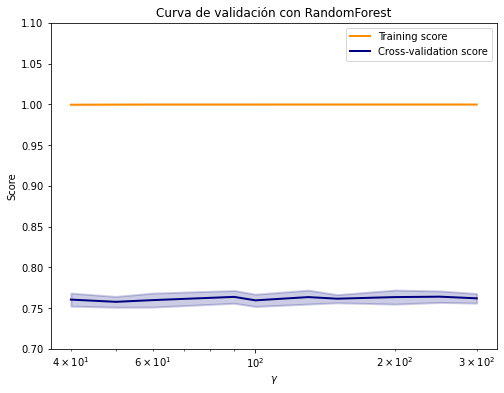

In [13]:
train_scores_mean = np.mean(train_score, axis=1)
train_scores_std = np.std(train_score, axis=1)
test_scores_mean = np.mean(test_score, axis=1)
test_scores_std = np.std(test_score, axis=1)

plt.title("Curva de validación con RandomForest")
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")
plt.ylim(0.7, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

Aqui observamos graficamente los resultados obtenidos anteriormente.

- A continuación, vamos a tratar de mejorar el *score* de nuestro modelo y para ello usaremos la función de RandomizedSearchCV que dado unos rangos en los parámetros que indicaremos a continuación, ira probando combinaciones aleatorias hasta un número de pruebas elegido por nosotros. La siguiente prueba ha llevado un total de 201.7 min

In [15]:
forest = RandomForestClassifier (random_state=32)

In [24]:
# Numero de arboles del bosque
n_estimators = [int(x) for x in np.linspace(start = 30, stop = 150, num = 10)]
# Numero de caracteristicas proporcionadas a cada arbol
max_features = [1,2,3,4,5,6,7,8,9,10,11,12,13]
max_features.append('auto')
# Profundidad de arbol
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimo valor para separar en subnodos
min_samples_split = [2, 5, 10]
# Minimo numero de muestras necesarias en hoja despues de dividir
min_samples_leaf = [1, 2,3, 4, 5]
# Numero maximo de nodos finales
max_leaf_nodes = [int(x) for x in np.linspace(10, 100, num = 19)]
max_leaf_nodes.append(None)
# Creacion de cuadrícula aleatoria
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               "max_leaf_nodes": max_leaf_nodes}
print(param_grid)

{'n_estimators': [30, 43, 56, 70, 83, 96, 110, 123, 136, 150], 'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 'auto'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 3, 4, 5], 'max_leaf_nodes': [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, None]}


Seleccionamos para la prueba un *cross val* de 5, definimos random_state, cantidad de mensajes que salga, uso de todas las CPUs disponibles.

In [25]:
forest_random = RandomizedSearchCV(estimator = forest, param_distributions = param_grid, n_iter = 3500, cv = 5, verbose=2, random_state=42, n_jobs = -1)

In [26]:
forest_random.fit(X_train, y_train)

Fitting 5 folds for each of 3500 candidates, totalling 17500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 24.4min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 31.1min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 39.1min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 48.1min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 57.7min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 67.8min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 78.7min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 90.8min
[Parallel(n_jobs=-1)]: Done 9097 tasks      | e

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

- A continuacion se puede ver la mejor configuración encontrada para las iteraciones probadas y el score obtenido para esa configuración.

In [27]:
forest_random.best_params_

{'n_estimators': 110,
 'min_samples_split': 10,
 'min_samples_leaf': 3,
 'max_leaf_nodes': None,
 'max_features': 1,
 'max_depth': 20}

In [29]:
forest_random.best_score_

0.7672357493183383

Respecto de la configuración por defecto donde se obtenía un *score* de 0.759 hemos conseguido una mejoría de 0.009. Tomaremos esta nueva configuración la que mejor ha clasificado para nuestro dataset de entrenamiento.

- En la siguiente gráfica se muestra la importancia de las características predictivas respecto de las demás.

In [39]:
best_forest = forest_random.best_estimator_

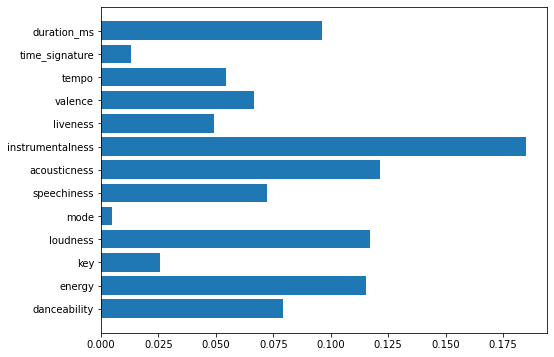

In [40]:
plt.barh(df_songs.loc[:,"danceability":"duration_ms"].columns, best_forest.feature_importances_);

- Con la mejor configuración obtenida, entrenamos el modelo con todo el dataset de entrenamiento y vemos resultados obtenidos, tanto con los datos de entrenamiento como con los de test.

In [41]:
best_forest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features=1,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=110,
                       n_jobs=None, oob_score=False, random_state=32, verbose=0,
                       warm_start=False)

In [42]:
print("Precisión sobre datos de pruebas: {:.4f}"
      .format(best_forest.score(X_test, y_test)))
print("Precisión sobre datos de train: {:.4f}"
      .format(best_forest.score(X_train, y_train)))

Precisión sobre datos de pruebas: 0.7662
Precisión sobre datos de train: 0.8829


Podemos ver como el *score* con los datos de entrenamiento, ha decrecido con respecto al modelo inicial, pero en cambio hemos mejorado un 0.003 el resultado sobre los resultados de test.

- En este punto almacenaremos nuestro modelo obtenido, para su posterior uso

In [2]:
filename = '../Models/forest_model_random_93_20.pkl'

In [30]:
joblib.dump(best_forest, filename)

['../Models/forest_model_random_93_20.pkl']

In [9]:
best_forest = joblib.load(filename) 

- Por último representamos la curva ROC para ver de manera visual lo bueno que es nuestro modelo obtenido

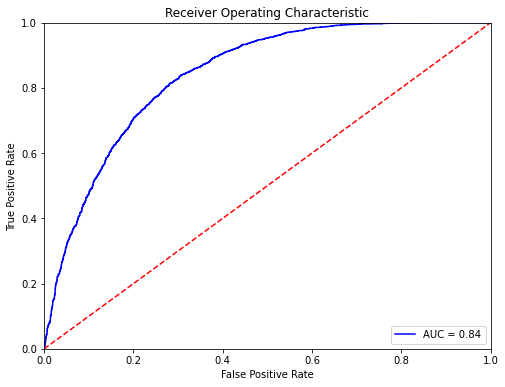

In [10]:
probs = best_forest.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

- Utilizando la función definida al principio del cuaderno, podemos hacer predicciones sobre cualquier canción de interés.

In [11]:
score = best_forest.predict_proba(find_song())
print('porcentaje de ser hit:', score[0][1]*100)

Artista: 

 billie eilish


Titulo: 

 bad guy


Canción elegida: bad guy de Billie Eilish
porcentaje de ser hit: 46.761806339461145


## AdaBoost
-  El segundo modelo que vamos a utilizar es AdaBoost que utiliza las técnicas de *boosting*, un modelo más avanzado que el anterior. 

In [35]:
from sklearn.ensemble import AdaBoostClassifier

In [7]:
ada_clf = AdaBoostClassifier()

- El proceso llevado a cabo es similar al del modelo anterior, veremos como funciona el modelo con la configuración por defecto y trataremos de buscar una mejor configuración de hiperparametros que nos haga tener unos mejores resultados utilizando *cross validation* y un modelo más generalizable.

In [10]:
%%time
cross_val_score(ada_clf,X_train,y_train,cv=5).mean()

Wall time: 3.35 s


0.7569396603419929

In [11]:
ada_clf.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [12]:
print("Precisión sobre el juego de pruebas: {:.4f}"
      .format(ada_clf.score(X_test, y_test)))
print("Precisión sobre el juego de train: {:.4f}"
      .format(ada_clf.score(X_train, y_train)))

Precisión sobre el juego de pruebas: 0.7553
Precisión sobre el juego de train: 0.7662


Como se puede observar, el modelo con la configuración por defecto da peores resultado que con *random forest*

In [13]:
param_range = [25,30,40,50,60,90,100,130]
train_score, test_score= validation_curve(
                                ada_clf,
                                X = X_train, y = y_train, 
                                param_name = 'n_estimators', 
                               param_range=param_range,
                                scoring="accuracy")

In [14]:
print("Numero de estimadores para un Cross_val 5 (test) y para todo dataset de entrenamiento (train)")
print ('n_estimators 25 en test:',test_score[0].mean(),'en train :',train_score[0].mean())
print ('n_estimators 30 en test:',test_score[1].mean(),'en train:',train_score[1].mean())
print ('n_estimators 40 en test:',test_score[2].mean(),'en train:',train_score[2].mean())
print ('n_estimators 50 en test:',test_score[3].mean(),'en train:',train_score[3].mean())
print ('n_estimators 60 en test:',test_score[4].mean(),'en train:',train_score[4].mean())
print ('n_estimators 90 en test:',test_score[5].mean(),'en train:',train_score[5].mean())
print ('n_estimators 100 en test:',test_score[6].mean(),'en train:',train_score[6].mean())
print ('n_estimators 130 en test:',test_score[7].mean(),'en train:',train_score[7].mean())

Numero de estimadores para un Cross_val 5 (test) y para todo dataset de entrenamiento (train)
n_estimators 25 en test: 0.7498372396869823 en train : 0.7591066038790212
n_estimators 30 en test: 0.7527695999609418 en train: 0.7627394649514427
n_estimators 40 en test: 0.7564189334768299 en train: 0.7654437285646443
n_estimators 50 en test: 0.7569396603419929 en train: 0.7670728441204049
n_estimators 60 en test: 0.7574610027988193 en train: 0.7681480638374856
n_estimators 90 en test: 0.7571353972635889 en train: 0.7700378001945054
n_estimators 100 en test: 0.7570050616493823 en train: 0.7710315402472518
n_estimators 130 en test: 0.7578519671868417 en train: 0.7729212792583323


- Definimos *Grid* de parámetros para buscar la mejor combinación 

In [8]:
# Numero de arboles del bosque
n_estimators = [int(x) for x in np.linspace(start = 30, stop = 150, num = 10)]
# Numero de caracteristicas proporcionadas a cada arbol
max_features = [1,2,3,4,5,6,7,8,9,10,11,12,13]
max_features.append('auto')
# Profundidad de arbol
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimo valor para separar en subnodos
min_samples_split = [2, 5, 10]
# Minimo numero de muestras necesarias en hoja despues de dividir
min_samples_leaf = [1, 2,3, 4, 5]
# Numero maximo de nodos finales
max_leaf_nodes = [int(x) for x in np.linspace(10, 100, num = 19)]
max_leaf_nodes.append(None)
#Algoritmo de implementacion
algorithm = ['SAMME', 'SAMME.R']
learning_rate = [round(float(x),2) for x in np.linspace(0.05, 1., num = 20)]
# Numero de muestras maximo que se le asigna a cada arbol
# max_samples
# Creacion de cuadrícula aleatoria
param_grid = {'n_estimators': n_estimators,
               'algorithm': algorithm,
              'learning_rate':learning_rate,
               'base_estimator__max_features': max_features,
               'base_estimator__max_depth': max_depth,
               'base_estimator__min_samples_split': min_samples_split,
               'base_estimator__min_samples_leaf': min_samples_leaf,
               "base_estimator__max_leaf_nodes": max_leaf_nodes}
print(param_grid)

{'n_estimators': [30, 43, 56, 70, 83, 96, 110, 123, 136, 150], 'algorithm': ['SAMME', 'SAMME.R'], 'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0], 'base_estimator__max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 'auto'], 'base_estimator__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'base_estimator__min_samples_split': [2, 5, 10], 'base_estimator__min_samples_leaf': [1, 2, 3, 4, 5], 'base_estimator__max_leaf_nodes': [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, None]}


In [36]:
from sklearn.tree import DecisionTreeClassifier

- Definimos estimador base y lanzamos la búsqueda aleatoria sobre el clasificador.

In [10]:
base_estimator = DecisionTreeClassifier(random_state=32)
ada_clf = AdaBoostClassifier(base_estimator=base_estimator, random_state=32)

In [11]:
ada_random = RandomizedSearchCV(estimator = ada_clf, param_distributions = param_grid, n_iter = 6250, cv = 5, verbose=2, random_state=32, n_jobs = -1)

In [12]:
ada_random.fit(X_train,y_train)

Fitting 5 folds for each of 6250 candidates, totalling 31250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 23.8min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 32.6min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 42.8min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 55.6min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 68.5min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 83.7min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 100.0min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 116.9min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 133.5min
[Parallel(n_jobs=-1)]: Done 9097 tasks      

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                                base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                      class_weight=None,
                                                                                      criterion='gini',
                                                                                      max_depth=None,
                                                                                      max_features=None,
                                                                                      max_leaf_nodes=None,
                                                                                      min_impurity_decrease=0.0,
                                                                                      min_impurity_split=None,
                                         

- A continuación observamos la mejor configuración de hiperparametros encontrada, para un mayor *score* obtenido para un *cross val* de 5.

In [13]:
ada_random.best_params_

{'n_estimators': 43,
 'learning_rate': 0.05,
 'base_estimator__min_samples_split': 2,
 'base_estimator__min_samples_leaf': 4,
 'base_estimator__max_leaf_nodes': 70,
 'base_estimator__max_features': 4,
 'base_estimator__max_depth': 110,
 'algorithm': 'SAMME'}

In [14]:
ada_random.best_score_

0.7702986362521931

Como se puede observar hemos mejorado el *score* un 0.15 con esta nueva configuración con respecto al modelo que usaba la configuración por defecto.

- A continuación se muestra como en el caso anterior de *random forest*, la importancia que le ha dado el modelo a cada una de las características respecto de las otras.

In [16]:
best_ada = ada_random.best_estimator_

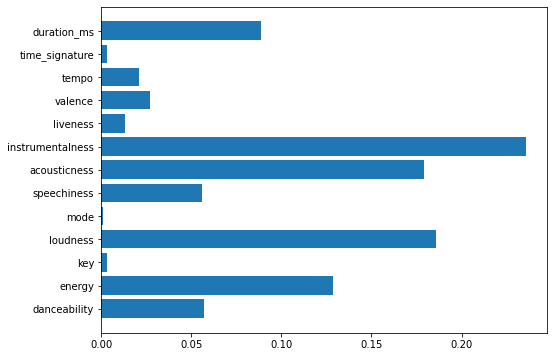

In [17]:
plt.barh(df_songs.loc[:,"danceability":"duration_ms"].columns, best_ada.feature_importances_);

-  Para la configuración obtenida, entrenamos el modelo con todo el dataset de entrenamiento y vemos los resultados obtenidos.

In [19]:
best_ada.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=110,
                                                         max_features=4,
                                                         max_leaf_nodes=70,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=4,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                               

In [20]:
print("Precisión sobre el juego de pruebas: {:.4f}"
      .format(best_ada.score(X_test, y_test)))
print("Precisión sobre el juego de train: {:.4f}"
      .format(best_ada.score(X_train, y_train)))

Precisión sobre el juego de pruebas: 0.7654
Precisión sobre el juego de train: 0.7986


Podemos ver como el *score* con los datos de entrenamiento, ha aumentado con respecto al modelo inicial, también hemos mejorado el resultado sobre los resultados de test, en este caso 0.1, mejorando por tanto los resultados de entrenamiento y de test.

- Guardamos nuestro modelo obtenido, para su posterior uso

In [12]:
filename = '../Models/ada_boost_model_random_93_20.pkl'

In [32]:
joblib.dump(best_ada, filename)

['../Models/ada_boost_model_random_93_20.pkl']

In [13]:
best_ada = joblib.load(filename) 

- Representamos la curva ROC para ver de manera visual lo bueno que es nuestro modelo obtenido

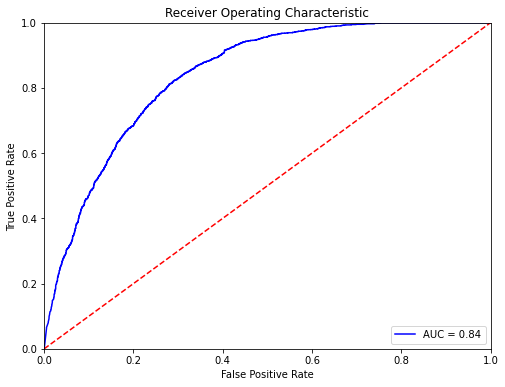

In [24]:
probs = best_ada.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

- Utilizando la función definida al principio del cuaderno, podemos hacer predicciones sobre cualquier canción de interés.

In [14]:
score = best_ada.predict_proba(find_song())
print('porcentaje de ser hit:', score[0][1]*100)

Artista: 

 billie eilish


Titulo: 

 bad guy


Canción elegida: bad guy de Billie Eilish
porcentaje de ser hit: 30.477130731039416


## Gradient Boosting
- La siguiente técnica que utilizaremos será GradientBoosting, y para ello lo haremos usando la implementación de LightGBM.

In [37]:
import lightgbm as lgb

In [8]:
lgb_clf =lgb.LGBMClassifier()

In [9]:
%%time
cross_val_score(lgb_clf, X_train,y_train, cv=5).mean()

Wall time: 1 s


0.7638474266676432

In [10]:
lgb_clf.fit(X_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [11]:
print("Precisión sobre el juego de pruebas: {:.4f}"
      .format(lgb_clf.score(X_test, y_test)))
print("Precisión sobre el juego de train: {:.4f}"
      .format(lgb_clf.score(X_train, y_train)))

Precisión sobre el juego de pruebas: 0.7690
Precisión sobre el juego de train: 0.8361


Como se puede observar, por defecto ya somos capaces de obtener un buen *score* si lo comparamos con los modelos previamente probados

In [12]:
param_range = [60,90,100,150,200,250,300]
train_score, test_score= validation_curve(
                                lgb_clf,
                                X = X_train, y = y_train, 
                                param_name = 'n_estimators', 
                               param_range=param_range,
                                scoring="accuracy")

In [13]:
print("Numero de estimadores para un Cross_val 5 (test) y para todo dataset de entrenamiento (train)")
print ('n_estimators 60 en test:',test_score[0].mean(),'en train :',train_score[0].mean())
print ('n_estimators 90 en test:',test_score[1].mean(),'en train:',train_score[1].mean())
print ('n_estimators 100 en test:',test_score[2].mean(),'en train:',train_score[2].mean())
print ('n_estimators 150 en test:',test_score[3].mean(),'en train:',train_score[3].mean())
print ('n_estimators 200 en test:',test_score[4].mean(),'en train:',train_score[4].mean())
print ('n_estimators 250 en test:',test_score[5].mean(),'en train:',train_score[5].mean())
print ('n_estimators 300 en test:',test_score[6].mean(),'en train:',train_score[6].mean())

Numero de estimadores para un Cross_val 5 (test) y para todo dataset de entrenamiento (train)
n_estimators 60 en test: 0.765476494481433 en train : 0.822722498072024
n_estimators 90 en test: 0.7635215239502304 en train: 0.8429720644449471
n_estimators 100 en test: 0.7638474266676432 en train: 0.8491463425994821
n_estimators 150 en test: 0.7633262540292066 en train: 0.8802619308456345
n_estimators 200 en test: 0.7600677999921459 en train: 0.906148219259282
n_estimators 250 en test: 0.7597421095477206 en train: 0.9284178469871887
n_estimators 300 en test: 0.7585040485765504 en train: 0.9459631271873938


- Definimos grid de parámetros sobre los que entrenar el modelo en busca del mejor resultado.

In [14]:
boosting_type = ['gbdt','dart']
#Numero de Hojas máximas por árboles
num_leaves = [int(x) for x in np.linspace(30, 110, num = 9)]
# Profundidad de arbol
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
#Learning rate
learning_rate = [round (float(x), 2) for x in np.linspace(0.1, 1., num = 10)]
learning_rate.append(0.005)
learning_rate = sorted(learning_rate)
# Numero de arboles del bosque
n_estimators = [int(x) for x in np.linspace(start = 30, stop = 150, num = 9)]
# Número de muestras para la construcción de contenedores
subsample_for_bin =  list(range(20000, 300000, 20000))
# Reducción mínima de pérdidas para realizar una nueva partición en un nodo del árbol.
min_split_gain =  [0.0,0.2,0.4,0.6,0.8]
#Número mínimo de datos necesarios en una hoja
min_child_samples = [int(x) for x in np.linspace(1, 40, num = 10)]
# reg_alpha
reg_alpha = [round (float(x), 2) for x in np.linspace(0.0, 1., num = 11)]
# reg_lambda
reg_lambda = [round (float(x), 2)  for x in np.linspace(0.0, 1., num = 11)]
# Creacion de cuadrícula aleatoria
param_grid = {'boosting_type':boosting_type,
              'num_leaves': num_leaves,
              'max_depth': max_depth,
              'learning_rate': learning_rate,
              'n_estimators': n_estimators,
              'subsample_for_bin': subsample_for_bin,
              'min_split_gain': min_split_gain,
              'min_child_samples':min_child_samples,
              'reg_alpha':reg_alpha,
              'reg_lambda':reg_lambda}
print(param_grid)

{'boosting_type': ['gbdt', 'dart'], 'num_leaves': [30, 40, 50, 60, 70, 80, 90, 100, 110], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'learning_rate': [0.005, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'n_estimators': [30, 45, 60, 75, 90, 105, 120, 135, 150], 'subsample_for_bin': [20000, 40000, 60000, 80000, 100000, 120000, 140000, 160000, 180000, 200000, 220000, 240000, 260000, 280000], 'min_split_gain': [0.0, 0.2, 0.4, 0.6, 0.8], 'min_child_samples': [1, 5, 9, 14, 18, 22, 27, 31, 35, 40], 'reg_alpha': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'reg_lambda': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}


- Lanzamos búsqueda aleatoria.

In [15]:
lgb_clf = lgb.LGBMClassifier(random_state=32)

In [18]:
light_gbm_random = RandomizedSearchCV(estimator = lgb_clf, param_distributions = param_grid, n_iter = 40000, cv = 5, verbose=2, random_state=42, n_jobs = -1)

In [19]:
light_gbm_random.fit(X_train, y_train)

Fitting 5 folds for each of 40000 candidates, totalling 200000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   56.4s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 16.5min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 22.6min
[Parallel(n_jobs=-1)]: Done 9097 tasks      | e

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective=None,
                                            random_state=32, reg_alpha=0.0,
                                            reg_lambda=0.0, silent...
                                        'num_leaves': [30, 40, 50, 60, 70, 80,
                                              

- Tras la búsqueda de hiperparametros, a continuación se muestra la mejor combinación encontrada, con el *score* obtenido.

In [20]:
light_gbm_random.best_params_

{'subsample_for_bin': 120000,
 'reg_lambda': 0.7,
 'reg_alpha': 0.9,
 'num_leaves': 40,
 'n_estimators': 150,
 'min_split_gain': 0.2,
 'min_child_samples': 35,
 'max_depth': 100,
 'learning_rate': 0.1,
 'boosting_type': 'dart'}

In [21]:
light_gbm_random.best_score_

0.7703635068771141

Podemos observar que respecto a la configuración por defecto hemos conseguido una mejora de 0.07.

- A continuación se muestra la importancia que le ha dado el modelo a cada una de las características respecto de las otras.

In [22]:
best_light_gbm = light_gbm_random.best_estimator_

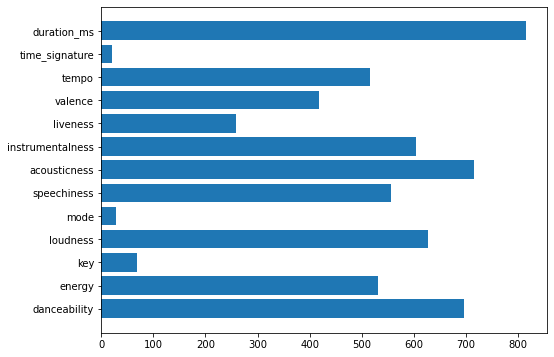

In [17]:
plt.barh(df_songs.loc[:,"danceability":"duration_ms"].columns, best_light_gbm.feature_importances_);

-  Para la configuración obtenida, entrenamos el modelo con todo el dataset de entrenamiento y vemos los resultados obtenidos.

In [18]:
best_light_gbm.fit(X_train,y_train)

LGBMClassifier(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=100,
               min_child_samples=35, min_child_weight=0.001, min_split_gain=0.2,
               n_estimators=150, n_jobs=-1, num_leaves=40, objective=None,
               random_state=32, reg_alpha=0.9, reg_lambda=0.7, silent=True,
               subsample=1.0, subsample_for_bin=120000, subsample_freq=0)

In [20]:
print("Precisión sobre el juego de pruebas: {:.4f}"
      .format(best_light_gbm.score(X_test, y_test)))
print("Precisión sobre el juego de train: {:.4f}"
      .format(best_light_gbm.score(X_train, y_train)))

Precisión sobre el juego de pruebas: 0.7645
Precisión sobre el juego de train: 0.8139


Para la configuración nueva hemos obtenido peores resultados globales tanto en test como en entrenamiento. Ya que hemos mejorado un 0.007 en *cross validation*, tomaremos la nueva configuración por lo que comentábamos, este modelo será más generalizable que el de por defecto y no tendera al sobreentrenamiento que lo que le permitirá ser un mejor clasificador.

- Guardamos nuestro modelo obtenido, para su posterior uso

In [15]:
filename = '../Models/light_gbm_model_random_93_20.pkl'

In [25]:
joblib.dump(best_light_gbm, filename)

['../Models/light_gbm_model_random_93_20.pkl']

In [16]:
best_light_gbm = joblib.load(filename) 

- Representamos la curva ROC para ver de manera visual lo bueno que es nuestro modelo obtenido

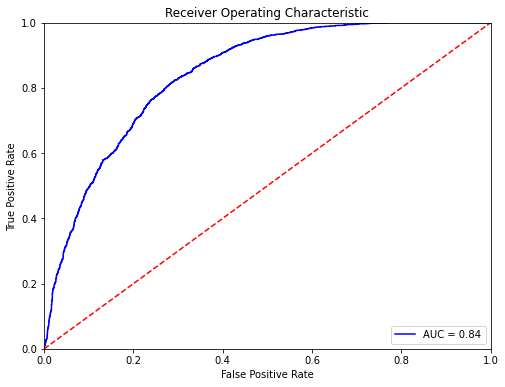

In [21]:
probs = best_light_gbm.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

- Utilizando la función definida al principio del cuaderno, podemos hacer predicciones sobre cualquier canción de interés.

In [23]:
score = best_light_gbm.predict_proba(find_song())
print('porcentaje de ser hit:', score[0][1]*100)

Artista: 

 billie eilish


Titulo: 

 bad guy


Canción elegida: bad guy de Billie Eilish
porcentaje de ser hit: 23.515944903992146


## Conclusiones

Tras ver los resultados obtenidos para estos tres modelos, podemos observar que el que mejor resultado obtiene en la clasificación para los datos de test es *random forest* con un 0.7662 seguido de Ada Boost con un 0.7654 y por último light gbm con un 0.7645. Hemos conseguido resultados muy parecidos otra vez. En el cuaderno 4_model_testing podremos a prueba estos modelos, con canciones actuales y analizaremos cuál es capaz de predecir mejor para canciones actuales.

# Año como feature

Como en el cuaderno 2_looking_predictive_model, realizaremos la inclusión del año como característica para ver el comportamiento de los modelos con este nuevo *feature*

- Primero definimos una función para poder hacer predicciones

In [28]:
def find_song_year():
    print("Artista: ", end="")
    artist = input()
    print("Titulo: ", end="")
    title = input()
    Searched = str (title + " " + artist)
    track = sp.search(Searched)
    try:
        id_track = track["tracks"]["items"][0]["uri"]
        track = sp.track(id_track)
        get_year = lambda date: parse(date, fuzzy=True).year
        year_realease = get_year(track["album"]["release_date"])
        track_feat = sp.audio_features(id_track)
        song = [[year_realease, track_feat[0]["danceability"], track_feat[0]["energy"],
                 track_feat[0]["key"],track_feat[0]["loudness"], track_feat[0]["mode"],
                 track_feat[0]["speechiness"],track_feat[0]["acousticness"],
                 track_feat[0]["instrumentalness"], track_feat[0]["liveness"],track_feat[0]["valence"],
                 track_feat[0]["tempo"],track_feat[0]["time_signature"],track["duration_ms"]]]
        
        print ("Canción elegida:",track["name"], "de", track["artists"][0]["name"] )
        return song
    except:
        print ("ERROR: Titulo no encontrado")

- Obtenemos el año del dataset para añadirlo como feature, para los *hits* tomaremos el año en el que han sido *hit* y para los no *hits* tomaremos el año de lanzamiento de la canción.

In [29]:
from dateutil.parser import parse

In [30]:
df_songs_year = pd.DataFrame.copy(df_songs)
get_year = lambda date: parse(date, fuzzy=True).year
df_songs_year.insert (12, "year", 0)
for i, item in df_songs_year.iterrows():
    if item['target']==0:
        year = get_year(item['release_date'])
    else:
        year = item['year_chart']
    df_songs_year.loc[i,'year'] = year

In [31]:
X = df_songs_year.loc[:,"year":"duration_ms"]
y = df_songs_year.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

### Random Forest

El proceso llevado a cabo será igual que en los casos anteriores.

In [38]:
forest = RandomForestClassifier ()

In [39]:
%%time
cross_val_score(forest,X_train,y_train,cv=5).mean()

Wall time: 9.96 s


0.815456593888873

Podemos observar como ya se pudo ver en el cuaderno anterior, una importante mejora en el acierto en el modelo al incluir esta característica.

In [40]:
forest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [42]:
print("Precisión sobre datos de pruebas: {:.4f}"
      .format(forest.score(X_test, y_test)))
print("Precisión sobre datos de train: {:.4f}"
      .format(forest.score(X_train, y_train)))

Precisión sobre datos de pruebas: 0.8122
Precisión sobre datos de train: 0.9999


Podemos ver como obtenemos un *score* que supera al del mejor *random forest* obtenido previamente, por 0.04 con la configuración por defecto.

In [16]:
param_range = [30,40,50,60,90,100,130,150,200,300]
train_score, test_score= validation_curve(
                                forest,
                                X = X_train, y = y_train, 
                                param_name = 'n_estimators', 
                               param_range=param_range,
                                scoring="accuracy")

In [17]:
print("Numero de estimadores para un Cross_val 5 (test) y para todo dataset de entrenamiento (train)")
print ('n_estimators 30 en test:',test_score[0].mean(),'en train:',train_score[0].mean())
print ('n_estimators 40 en test:',test_score[1].mean(),'en train:',train_score[1].mean())
print ('n_estimators 50 en test:',test_score[2].mean(),'en train:',train_score[2].mean())
print ('n_estimators 60 en test:',test_score[3].mean(),'en train:',train_score[3].mean())
print ('n_estimators 90 en test:',test_score[4].mean(),'en train:',train_score[4].mean())
print ('n_estimators 100 en test:',test_score[5].mean(),'en train:',train_score[5].mean())
print ('n_estimators 130 en test:',test_score[6].mean(),'en train:',train_score[6].mean())
print ('n_estimators 150 en test:',test_score[7].mean(),'en train:',train_score[7].mean())
print ('n_estimators 200 en test:',test_score[8].mean(),'en train:',train_score[8].mean())
print ('n_estimators 300 en test:',test_score[9].mean(),'en train:',train_score[9].mean())

Numero de estimadores para un Cross_val 5 (test) y para todo dataset de entrenamiento (train)
n_estimators 30 en test: 0.8037925328731255 en train: 0.999152875569963
n_estimators 40 en test: 0.8113514253600413 en train: 0.99956014384266
n_estimators 50 en test: 0.8106346643911003 en train: 0.999885962972721
n_estimators 60 en test: 0.8129806629922213 en train: 0.9998208004737392
n_estimators 90 en test: 0.8151308397625515 en train: 0.9999348348469574
n_estimators 100 en test: 0.812328857557396 en train: 0.9999511267987332
n_estimators 130 en test: 0.8144792466007136 en train: 0.9999511267987332
n_estimators 150 en test: 0.8148050219543338 en train: 0.9999511267987332
n_estimators 200 en test: 0.8150007164213321 en train: 0.9999511267987332
n_estimators 300 en test: 0.8145447328172978 en train: 0.9999511267987332


Podemos observar que sucede lo mismo que cuando no incluíamos el tiempo como feature, por tanto tenderemos a no usar unos números de estimador muy altos.

- Definimos *grid* con rangos de parámetros.

In [18]:
# Numero de arboles del bosque
n_estimators = [int(x) for x in np.linspace(start = 30, stop = 150, num = 10)]
# Numero de caracteristicas proporcionadas a cada arbol
max_features = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
max_features.append('auto')
# Profundidad de arbol
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimo valor para separar en subnodos
min_samples_split = [2, 5, 10]
# Minimo numero de muestras necesarias en hoja despues de dividir
min_samples_leaf = [1, 2,3, 4, 5]
# Numero maximo de nodos finales
max_leaf_nodes = [int(x) for x in np.linspace(10, 100, num = 19)]
max_leaf_nodes.append(None)
# Creacion de cuadrícula aleatoria
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               "max_leaf_nodes": max_leaf_nodes}
print(param_grid)

{'n_estimators': [30, 43, 56, 70, 83, 96, 110, 123, 136, 150], 'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 'auto'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 3, 4, 5], 'max_leaf_nodes': [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, None]}


- Realizamos búsqueda aleatoria

In [19]:
forest = RandomForestClassifier (random_state=32)

In [20]:
forest_random = RandomizedSearchCV(estimator = forest, param_distributions = param_grid, n_iter = 3500, cv = 5, verbose=2, random_state=32, n_jobs = -1)

In [21]:
forest_random.fit(X_train,y_train)

Fitting 5 folds for each of 3500 candidates, totalling 17500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 27.7min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 34.0min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 42.4min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 50.6min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 60.5min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 71.7min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 82.7min
[Parallel(n_jobs=-1)]: Done 9097 tasks      | e

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

- Tras la búsqueda de hiperparametros, a continuación se muestra la mejor combinación encontrada, con el *score* obtenido.

In [22]:
forest_random.best_params_

{'n_estimators': 150,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_leaf_nodes': None,
 'max_features': 11,
 'max_depth': 60}

In [23]:
forest_random.best_score_

0.817281462306155

Podemos observar que la mejora con respecto al modelo con valores por defecto, es muy leve.

- A continuación se muestra la importancia que le ha dado el modelo a cada una de las características respecto de las otras.

In [24]:
best_forest = forest_random.best_estimator_

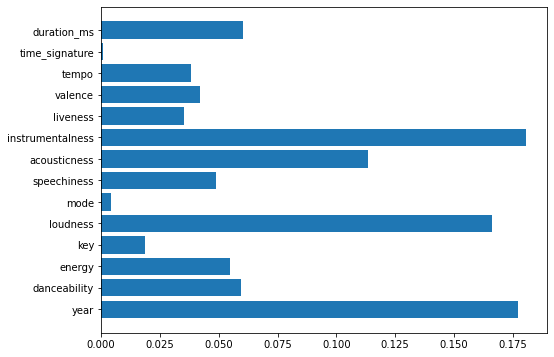

In [25]:
plt.barh(df_songs_year.loc[:,"year":"duration_ms"].columns, best_forest.feature_importances_);

Podemos observar como en este caso el año aunque tiene un peso importante con respecto a otras características, no tiene tanto importancia como lo tenía para el *random forest* del cuaderno 3_looking_predictive_model, en la que se usaba todo el dataset desde 1958, y el año tenía una importancia con respecto a todas las demás características muy superior.

- Para la configuración obtenida, entrenamos el modelo con todo el dataset de entrenamiento y vemos los resultados obtenidos.

In [26]:
best_forest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=60, max_features=11,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=32, verbose=0,
                       warm_start=False)

In [27]:
print("Precisión sobre datos de pruebas: {:.4f}"
      .format(best_forest.score(X_test, y_test)))
print("Precisión sobre datos de train: {:.4f}"
      .format(best_forest.score(X_train, y_train)))

Precisión sobre datos de pruebas: 0.8098
Precisión sobre datos de train: 0.9478


Se puede observar un descenso en la predicción de los datos de entrenamiento, y un resultado prácticamente idéntico en los resultados de test con la configuración por defecto. Tomaremos este modelo como mejor respecto, ya que tiene un mejor  *score* usando *cross validation*.

- Guardamos nuestro modelo obtenido, para su posterior uso

In [25]:
filename = '../Models/forest_model_random_year_93_20.pkl'

In [28]:
joblib.dump(best_forest, filename)

['../Models/forest_model_random_year_93_20.pkl']

In [26]:
best_forest = joblib.load(filename) 

- Representamos la curva ROC para ver de manera visual lo bueno que es nuestro modelo obtenido

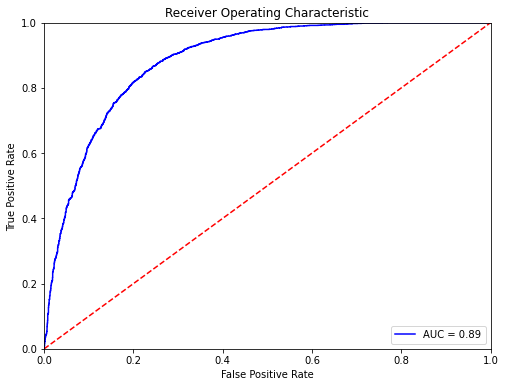

In [43]:
probs = best_forest.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

- Utilizando la función definida al principio del cuaderno, podemos hacer predicciones sobre cualquier canción de interés.

In [44]:
score = best_forest.predict_proba(find_song_year())
print('porcentaje de ser hit:', score[0][1]*100)

Artista: 

 billie eilish


Titulo: 

 bad guy


Canción elegida: bad guy de Billie Eilish
porcentaje de ser hit: 45.13276353276353


## AdaBoost
- Utilizaremos AdaBoost para entrenar el dataset

In [13]:
ada_clf = AdaBoostClassifier()

In [14]:
%%time
cross_val_score(ada_clf,X_train,y_train,cv=5).mean()

Wall time: 2.9 s


0.7998824432196292

Como para *random forest* obtenemos mejores resultados que cuando no incluíamos el año como característica.

In [15]:
ada_clf.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [16]:
print("Precisión sobre el juego de pruebas: {:.4f}"
      .format(ada_clf.score(X_test, y_test)))
print("Precisión sobre el juego de train: {:.4f}"
      .format(ada_clf.score(X_train, y_train)))

Precisión sobre el juego de pruebas: 0.7891
Precisión sobre el juego de train: 0.8053


- Definimos el *grid* de entrenamiento y se lanza la búsqueda de la mejor combinación de hiperparametros.

In [17]:
# Numero de arboles del bosque
n_estimators = [int(x) for x in np.linspace(start = 30, stop = 150, num = 10)]
# Numero de caracteristicas proporcionadas a cada arbol
max_features = [1,2,3,4,5,6,7,8,9,10,11,12,13]
max_features.append('auto')
# Profundidad de arbol
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimo valor para separar en subnodos
min_samples_split = [2, 5, 10]
# Minimo numero de muestras necesarias en hoja despues de dividir
min_samples_leaf = [1, 2,3, 4, 5]
# Numero maximo de nodos finales
max_leaf_nodes = [int(x) for x in np.linspace(10, 100, num = 10)]
max_leaf_nodes.append(None)
#Algoritmo de implementacion
algorithm = ['SAMME', 'SAMME.R']
learning_rate = [float(x) for x in np.linspace(0.05, 1., num = 20)]
# Creacion de cuadrícula aleatoria
param_grid = {'n_estimators': n_estimators,
               'algorithm': algorithm,
              'learning_rate':learning_rate,
               'base_estimator__max_features': max_features,
               'base_estimator__max_depth': max_depth,
               'base_estimator__min_samples_split': min_samples_split,
               'base_estimator__min_samples_leaf': min_samples_leaf,
               "base_estimator__max_leaf_nodes": max_leaf_nodes}
print(param_grid)

{'n_estimators': [30, 43, 56, 70, 83, 96, 110, 123, 136, 150], 'algorithm': ['SAMME', 'SAMME.R'], 'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.39999999999999997, 0.44999999999999996, 0.49999999999999994, 0.5499999999999999, 0.6, 0.65, 0.7, 0.75, 0.7999999999999999, 0.85, 0.9, 0.95, 1.0], 'base_estimator__max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 'auto'], 'base_estimator__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'base_estimator__min_samples_split': [2, 5, 10], 'base_estimator__min_samples_leaf': [1, 2, 3, 4, 5], 'base_estimator__max_leaf_nodes': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None]}


In [18]:
from sklearn.tree import DecisionTreeClassifier

In [19]:
base_estimator = DecisionTreeClassifier(random_state=32)
ada_clf = AdaBoostClassifier(base_estimator=base_estimator, random_state=32)

In [20]:
ada_random = RandomizedSearchCV(estimator = ada_clf, param_distributions = param_grid, n_iter = 3250, cv = 5, verbose=2, random_state=32, n_jobs = -1)

In [21]:
ada_random.fit(X_train,y_train)

Fitting 5 folds for each of 3250 candidates, totalling 16250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 17.2min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 24.4min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 33.1min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 41.3min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 52.0min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 65.1min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 79.2min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 94.9min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 111.8min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 132.1min
[Parallel(n_jobs=-1)]: Done 9097 tasks      |

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                                base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                      class_weight=None,
                                                                                      criterion='gini',
                                                                                      max_depth=None,
                                                                                      max_features=None,
                                                                                      max_leaf_nodes=None,
                                                                                      min_impurity_decrease=0.0,
                                                                                      min_impurity_split=None,
                                         

- Tras la búsqueda de hiperparametros, a continuación se muestra la mejor combinación encontrada, con el *score* obtenido.

In [22]:
ada_random.best_params_

{'n_estimators': 96,
 'learning_rate': 0.05,
 'base_estimator__min_samples_split': 5,
 'base_estimator__min_samples_leaf': 3,
 'base_estimator__max_leaf_nodes': 80,
 'base_estimator__max_features': 7,
 'base_estimator__max_depth': 30,
 'algorithm': 'SAMME'}

In [23]:
ada_random.best_score_

0.8184544616067155

Podemos observar como hemos conseguido para esta configuración una mejoría del 0.018.

- A continuación se muestra la importancia que le ha dado el modelo a cada una de las características respecto de las otras.

In [24]:
best_ada = ada_random.best_estimator_

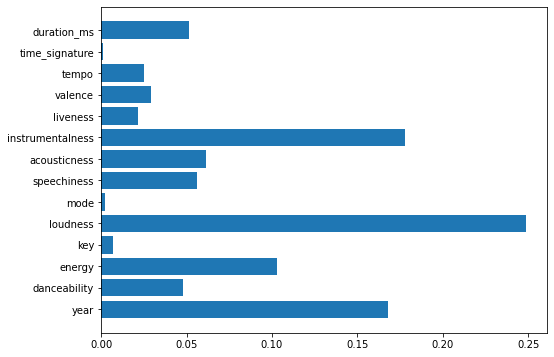

In [25]:
plt.barh(df_songs_year.loc[:,"year":"duration_ms"].columns, best_ada.feature_importances_);

Para Ada Boost se puede ver que la caracteristica de volumen (*loudness*) gana en importancia al año y esta tiene un peso muy similar a instrumentalidad (*instrumentalness*).

-  Para la configuración obtenida, entrenamos el modelo con todo el dataset de entrenamiento y vemos los resultados obtenidos.

In [26]:
best_ada.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=30,
                                                         max_features=7,
                                                         max_leaf_nodes=80,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=3,
                                                         min_samples_split=5,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                                

In [27]:
print("Precisión sobre datos de pruebas: {:.4f}"
      .format(best_ada.score(X_test, y_test)))
print("Precisión sobre datos de train: {:.4f}"
      .format(best_ada.score(X_train, y_train)))

Precisión sobre datos de pruebas: 0.8149
Precisión sobre datos de train: 0.8600


Como se puede observar, respecto de la configuración por defecto se ha conseguido una mejoría de 0.026 en los resultados de test y una mejora tambien en entrenamiento de 0.0547.

- Guardamos nuestro modelo obtenido, para su posterior uso

In [4]:
filename = '../Models/ada_boost_model_random_year_93_20.pkl'

In [5]:
joblib.dump(best_ada, filename)

['../Models/ada_boost_model_random_year_93_20.pkl']

In [45]:
best_ada = joblib.load(filename)

- Representamos la curva ROC para ver de manera visual lo bueno que es nuestro modelo obtenido

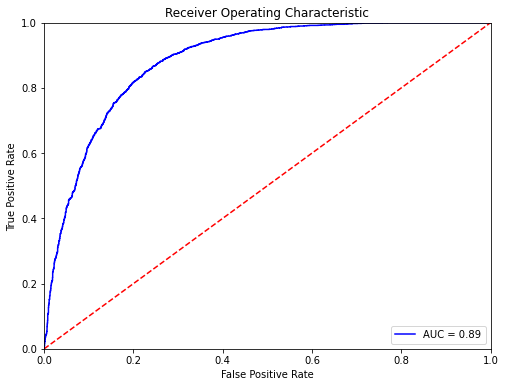

In [46]:
probs = best_ada.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

- Utilizando la función definida al principio del cuaderno, podemos hacer predicciones sobre cualquier canción de interés.

In [47]:
score = best_ada.predict_proba(find_song_year())
print('porcentaje de ser hit:', score[0][1]*100)

Artista: 

 billie eilish


Titulo: 

 bad guy


Canción elegida: bad guy de Billie Eilish
porcentaje de ser hit: 45.13276353276353


## LightGBM
- Realizamos los entrenamientos y análisis de resultados utilizando la implementación de *gradient boosting* de lightgbm

In [10]:
import lightgbm as lgb

In [11]:
lgb_clf =lgb.LGBMClassifier()

In [12]:
%%time
cross_val_score(lgb_clf,X_train,y_train,cv=5).mean()

Wall time: 992 ms


0.8170857466118578

Al igual que para los 2 casos anteriores, obtenemos un score bastante alto en comparación de cuando no teníamos incluido el año como característica.

In [13]:
lgb_clf.fit(X_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [14]:
print("Precisión sobre el juego de pruebas: {:.4f}"
      .format(lgb_clf.score(X_test, y_test)))
print("Precisión sobre el juego de train: {:.4f}"
      .format(lgb_clf.score(X_train, y_train)))

Precisión sobre el juego de pruebas: 0.8178
Precisión sobre el juego de train: 0.8750


- Definimos el *grid* de entrenamiento y se lanza la búsqueda de la mejor combinación de hiperparametros.

In [16]:
boosting_type = ['gbdt','dart']
#Numero de Hojas máximas por árboles
num_leaves = [int(x) for x in np.linspace(30, 110, num = 9)]
# Profundidad de arbol
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
#Learning rate
learning_rate = [round (float(x), 2) for x in np.linspace(0.1, 1., num = 10)]
learning_rate.append(0.005)
learning_rate = sorted(learning_rate)
# Numero de arboles del bosque
n_estimators = [int(x) for x in np.linspace(start = 30, stop = 150, num = 9)]
# Número de muestras para la construcción de contenedores
subsample_for_bin =  list(range(20000, 300000, 20000))
# Reducción mínima de pérdidas para realizar una nueva partición en un nodo del árbol.
min_split_gain =  [0.0,0.2,0.4,0.6,0.8]
#Número mínimo de datos necesarios en una hoja
min_child_samples = [int(x) for x in np.linspace(1, 40, num = 10)]
# reg_alpha
reg_alpha = [round (float(x), 2) for x in np.linspace(0.0, 1., num = 11)]
# reg_lambda
reg_lambda = [round (float(x), 2)  for x in np.linspace(0.0, 1., num = 11)]
# Creacion de cuadrícula aleatoria
param_grid = {'boosting_type':boosting_type,
              'num_leaves': num_leaves,
              'max_depth': max_depth,
              'learning_rate': learning_rate,
              'n_estimators': n_estimators,
              'subsample_for_bin': subsample_for_bin,
              'min_split_gain': min_split_gain,
              'min_child_samples':min_child_samples,
              'reg_alpha':reg_alpha,
              'reg_lambda':reg_lambda}
print(param_grid)

{'boosting_type': ['gbdt', 'dart'], 'num_leaves': [30, 40, 50, 60, 70, 80, 90, 100, 110], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'learning_rate': [0.005, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'n_estimators': [30, 45, 60, 75, 90, 105, 120, 135, 150], 'subsample_for_bin': [20000, 40000, 60000, 80000, 100000, 120000, 140000, 160000, 180000, 200000, 220000, 240000, 260000, 280000], 'min_split_gain': [0.0, 0.2, 0.4, 0.6, 0.8], 'min_child_samples': [1, 5, 9, 14, 18, 22, 27, 31, 35, 40], 'reg_alpha': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'reg_lambda': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}


In [17]:
lgb_clf = lgb.LGBMClassifier(random_state=32)

In [20]:
light_gbm_random = RandomizedSearchCV(estimator = lgb_clf, param_distributions = param_grid, n_iter = 40000, cv = 5, verbose=2, random_state=32, n_jobs = -1)

In [21]:
light_gbm_random.fit(X_train,y_train)

Fitting 5 folds for each of 40000 candidates, totalling 200000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 21.0min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 24.3min
[Parallel(n_jobs=-1)]: Done 9097 tasks      | e

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective=None,
                                            random_state=32, reg_alpha=0.0,
                                            reg_lambda=0.0, silent...
                                        'num_leaves': [30, 40, 50, 60, 70, 80,
                                              

- Tras la búsqueda de hiperparametros, a continuación se muestra la mejor combinación encontrada, con el *score* obtenido.

In [22]:
light_gbm_random.best_params_

{'subsample_for_bin': 100000,
 'reg_lambda': 0.6,
 'reg_alpha': 0.8,
 'num_leaves': 50,
 'n_estimators': 60,
 'min_split_gain': 0.8,
 'min_child_samples': 27,
 'max_depth': 80,
 'learning_rate': 0.2,
 'boosting_type': 'dart'}

In [ ]:
0.8170857466118578

In [23]:
light_gbm_random.best_score_

0.8208001630256542

Hemos conseguido una pequeña mejora respecto al modelo por defecto, una mejora de 0.003.

- A continuación se muestra la importancia que le ha dado el modelo a cada una de las características respecto de las otras.

In [24]:
best_lgb = light_gbm_random.best_estimator_

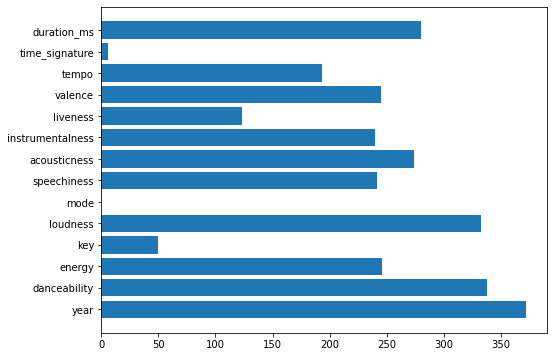

In [25]:
plt.barh(df_songs_year.loc[:,"year":"duration_ms"].columns, best_lgb.feature_importances_);

Para lightGBM podemos observar como varias características tienen un peso importante, la ganadora es el año pero no difiere mucho respecto de las demás características.

-  Para la configuración obtenida, entrenamos el modelo con todo el dataset de entrenamiento y vemos los resultados obtenidos.

In [26]:
best_lgb.fit(X_train,y_train)

LGBMClassifier(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.2, max_depth=80,
               min_child_samples=27, min_child_weight=0.001, min_split_gain=0.8,
               n_estimators=60, n_jobs=-1, num_leaves=50, objective=None,
               random_state=32, reg_alpha=0.8, reg_lambda=0.6, silent=True,
               subsample=1.0, subsample_for_bin=100000, subsample_freq=0)

In [27]:
print("Precisión sobre el juego de pruebas: {:.4f}"
      .format(best_lgb.score(X_test, y_test)))
print("Precisión sobre el juego de train: {:.4f}"
      .format(best_lgb.score(X_train, y_train)))

Precisión sobre el juego de pruebas: 0.8168
Precisión sobre el juego de train: 0.8671


- Guardamos nuestro modelo obtenido, para su posterior uso

In [49]:
filename = '../Models/light_gbm_model_random_year_93_20.pkl'

In [30]:
joblib.dump(best_lgb, filename)

['../Models/light_gbm_model_random_year_93_20.pkl']

In [50]:
best_lgb = joblib.load(filename)

- Representamos la curva ROC para ver de manera visual lo bueno que es nuestro modelo obtenido

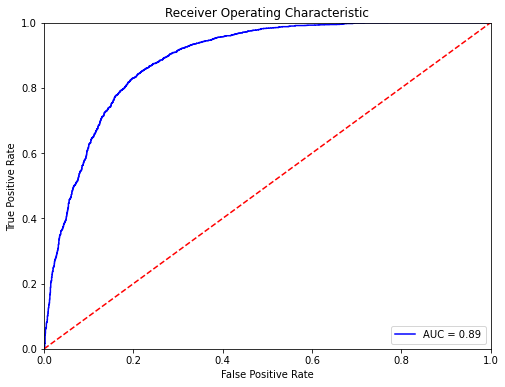

In [51]:
probs = best_lgb.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

- Utilizando la función definida al principio del cuaderno, podemos hacer predicciones sobre cualquier canción de interés.

In [52]:
score = best_lgb.predict_proba(find_song_year())
print('porcentaje de ser hit:', score[0][1]*100)

Artista: 

 billie eilish


Titulo: 

 bad guy


Canción elegida: bad guy de Billie Eilish
porcentaje de ser hit: 36.350180818750836
